In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import json
import logging
import os
from typing import Dict, List, Literal, Union

from nltk.metrics import masi_distance
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests


_Emotion = str
_AnnotatedEmotion = List[_Emotion]
_AgreementScore = float


flatten = lambda x: [p for q in x for p in q]


class ThaiSERAnnotationAnalyzer:

    DEFAULT_EMOTIONS = ["Neutral", "Angry", "Happy", "Sad", "Frustrated", "other"]
    DEFAULT_AGREEMENT_THRESHOLD = 0.71
    DEFAULT_LABEL_PATH = "data/emotion_label.json"
    DEFAULT_LABEL_URL = "https://github.com/vistec-AI/dataset-releases/releases/download/v1/emotion_label.json"
    DEFAULT_DEMOGRAPHY_PATH = "data/actor_demography.json"
    DEFAULT_DEMOGRAPHY_URL = "https://github.com/vistec-AI/dataset-releases/releases/download/v1/actor_demography.json"

    def __init__(
        self,
        agreement_threshold: float = DEFAULT_AGREEMENT_THRESHOLD,
        do_recalculate_agreement: bool = True,
    ):
        self._emotions = ThaiSERAnnotationAnalyzer.DEFAULT_EMOTIONS
        self.agreement_threshold = agreement_threshold
        self.do_recalculate_agreement = do_recalculate_agreement
        self.setup()

    @property
    def emotions(self) -> List[_Emotion]:
        return self._emotions
    
    @staticmethod
    def load_json_from_url(url: str) -> dict:
        response = requests.get(url)
        response.raise_for_status()  # Optional: raises an exception for HTTP errors
        return response.json()
    
    def load_labels(self) -> pd.DataFrame:
        if os.path.exists(ThaiSERAnnotationAnalyzer.DEFAULT_LABEL_PATH):
            with open(ThaiSERAnnotationAnalyzer.DEFAULT_LABEL_PATH, "r") as fp:
                emotion_label = json.load(fp)
        else:
            logging.warning(f"File {ThaiSERAnnotationAnalyzer.DEFAULT_LABEL_PATH} does not exist, downloading from {ThaiSERAnnotationAnalyzer.DEFAULT_LABEL_PATH}")
            emotion_label = ThaiSERAnnotationAnalyzer.load_json_from_url(ThaiSERAnnotationAnalyzer.DEFAULT_LABEL_URL)

        label_df = []
        for f_name, annotation in emotion_label.items():
            assert len(annotation) == 1
            annotation = annotation[0]

            assigned_emo = annotation["assigned_emo"]
            majority_emo = annotation["majority_emo"]
            per_annotator_annotation = annotation["annotated"] # list[list[emotion]]

            # sanity check
            assert assigned_emo in ThaiSERAnnotationAnalyzer.DEFAULT_EMOTIONS
            assert majority_emo in ThaiSERAnnotationAnalyzer.DEFAULT_EMOTIONS + ["None", "other"], majority_emo
            for _a in per_annotator_annotation:
                for ai in _a:
                    assert ai in ThaiSERAnnotationAnalyzer.DEFAULT_EMOTIONS + ["other"], ai

            label_df.append({"wav": f_name, **annotation})
        label_df = pd.DataFrame(label_df)
        return label_df
    
    def load_demography(self) -> pd.DataFrame:
        if os.path.exists(ThaiSERAnnotationAnalyzer.DEFAULT_DEMOGRAPHY_PATH):
            with open(ThaiSERAnnotationAnalyzer.DEFAULT_DEMOGRAPHY_PATH, "r") as fp:
                actor_demography = json.load(fp)
            actor_df = pd.DataFrame(actor_demography["data"])
        else:
            logging.warning(f"File {ThaiSERAnnotationAnalyzer.DEFAULT_DEMOGRAPHY_PATH} does not exist, downloading from {ThaiSERAnnotationAnalyzer.DEFAULT_DEMOGRAPHY_PATH}")
            actor_df = pd.DataFrame(ThaiSERAnnotationAnalyzer.load_json_from_url(ThaiSERAnnotationAnalyzer.DEFAULT_DEMOGRAPHY_URL)["data"])
        return actor_df
    
    @staticmethod
    def calculate_agreement(
        annotated: List[_AnnotatedEmotion],
        ignore_select_all: bool = False, # whether to ignore select all
    ) -> Dict[_Emotion, _AgreementScore]:
        agreement_dict = {k: 0 for k in set(flatten(annotated))}
        for a in annotated:
            # assign score to 0 if annotator select all emotion
            score = 0 if len(a) == 5 and ignore_select_all else 1/len(a)
            for ai in a:
                agreement_dict[ai] += score
        agreement_dict = {k: v/len(annotated) for k, v in agreement_dict.items()}
        agreement_dict
        return agreement_dict
    
    def recalculate_agreement(
        self, 
        ignore_select_all: bool = False,
        error_thresh: float = 1e-3,
    ):
        fix_agreements = []
        n_mismatch = 0
        for i, row in self.labels.iterrows():
            calc_agreement = ThaiSERAnnotationAnalyzer.calculate_agreement(
                row.annotated, ignore_select_all=ignore_select_all
            )

            if row.majority_emo == "None":
                # Check if there are multiple emotions with maximum agreement
                max_agreement = max(calc_agreement.values())
                max_emotions = [emotion for emotion, score in calc_agreement.items() if score == max_agreement]
                assert len(max_emotions) > 1, "Expected multiple emotions with max agreement when majority_emo is None"
                # assign 0 to agreement is no consensus
                fix_agreements.append(0.)
                continue

            if abs(row.agreement - calc_agreement[row.majority_emo]) > error_thresh:
                n_mismatch += 1

            fix_agreements.append(calc_agreement[row.majority_emo])

        # print(f"Found {n_mismatch} mismatch agreements")
        self.labels["old_agreement"] = self.labels["agreement"].copy()
        self.labels["agreement"] = fix_agreements
        
    def setup(self):
        self.demography = self.load_demography()
        self.labels = self.load_labels()

        if self.do_recalculate_agreement:
            self.recalculate_agreement()

        # filter aggrement
        self.labels = self.labels[self.labels["agreement"] >= self.agreement_threshold]

    def __len__(self):
        return len(self.labels)
    
    def __repr__(self):
        return f"ThaiSERAnnotationAnalyzer(agreement_threshold={self.agreement_threshold}, recalculate_agreement={self.do_recalculate_agreement})"
    
    def get_demography_stats(self) -> Dict[Literal["gender", "age"], Union[pd.Series, pd.DataFrame]]:
        actor_df = self.demography.copy()
        gender_stats = actor_df.groupby("Sex").size()
        # bin age by <20, 20-29, 30-39, 40-49, 50+
        actor_df["AgeGroup"] = pd.cut(actor_df["Age"], bins=[0, 20, 29, 39, 49, 100], labels=["<20", "20-29", "30-39", "40-49", "50+"])
        age_stats = actor_df.groupby(["Sex", "AgeGroup"], as_index=False).size().sort_values("Sex", ascending=False)
        return {"gender": gender_stats, "age": age_stats}
    
    def set_agreement_threshold(self, agreement_threshold: float):
        self.agreement_threshold = agreement_threshold
        self.setup()

    def get_V(self) -> List[_AnnotatedEmotion]:
        """
        Build the 'value_domain' = all possible sets of emotions that appear.
        We store them as sorted lists, e.g. ["Angry", "Sad"].
        """
        convert_annotation_to_keys = lambda x: ",".join(sorted(x))

        value_domain = set(flatten(
            self.labels["annotated"].map(
                lambda x: [convert_annotation_to_keys(a) for a in x]
            ).values
        ))

        value_domain = [vi.split(",") for vi in value_domain]
        value_domain.sort()
        return value_domain
    
    def count_value(self) -> np.ndarray:
        """Create a matrix of size NxV where row represent data entry
        and column represent its count of how much annotator annotate such value"""
        V = self.get_V()
        value_counts = np.array([
            [sum(1 for a in annotation if sorted(a) == v) for v in V]
            for annotation in self.labels["annotated"]
        ])
        return value_counts
    
    def get_O(self) -> np.ndarray:
        """Get coincidence matrix"""
        V = self.get_V()
        value_counts = self.count_value()
        value_count_matrices = value_counts[:, :, None] # NxVx1
        num_annotation = np.maximum(np.sum(value_counts, axis=1), 2)
        identity_3d = np.tile(np.eye(len(V)), (len(value_counts), 1, 1)) # NxVxV
        diagonals = identity_3d * value_counts[:, None, :] # broadcast annotation vector to diagnoal matrix

        # NxVx1 * Nx1xV - broadcast outer product (V -> VxV)
        # O[i,j] represents value_counts[i] * value_counts[j]
        # e.g. consider a single sample annotator select [["Angry", "Happy"], ["Angry"], ["Happy"], ["Happy"]]
        # we treat value index as ["Angry"]: 0, ["Happy"]: 1, ["Angry", "Happy"]: 2
        # value_counts become [1, 2, 1]
        # outer product becomes
        # [[1, 2, 1],
        #  [2, 4, 2],
        #  [1, 2, 1]]
        # consider case where i != j
        # at position (0, 1) which is how many total combination pairs exists where annotators both select
        # [["Angry"], ["Happy"]] at the same time = how many time annotator select ["Angry"] * how many time annotator select ["Happy"]
        # but for position where i = j, it always counted itself pairing with itself
        # subtracting value_counts[i] (diagnoal) is necessary to remove self-pairing
        # unnormalized_O now becomes NxVxV where for each sample, it is a VxV matrix
        # each VxV matrix shows a number of "how many possible pair exists" for each value pair v[i] and v[j]
        unnormalized_O = value_count_matrices * value_count_matrices.transpose((0, 2, 1)) - diagonals
        # normalize by number of annotator - 1
        # and sum along N axis to get a single VxV matrix
        O = np.sum(np.divide(
            unnormalized_O,
            (num_annotation - 1)[:, None, None]
        ), axis=0)
        return O
    
    def get_E(self, O: np.ndarray) -> np.ndarray:
        """Get random coincidence matrix"""
        V = self.get_V()
        marginalized_sum_O = np.sum(O, axis=0)[:, None] # n_v (V,1)
        sum_O = np.sum(marginalized_sum_O) # n (scalar)

        E = (marginalized_sum_O.dot(marginalized_sum_O.T) - np.eye(len(V)) * marginalized_sum_O) / (sum_O - 1)
        return E
    
    def get_delta_matrix(self) -> np.ndarray:
        """Get distance delta matrix, we use MASI distance for Thai SER"""
        V = self.get_V()
        delta = np.zeros((len(V), len(V)))
        for i, v in enumerate(V):
            for j, v_prime in enumerate(V):
                delta[i, j] = masi_distance(set(v), set(v_prime))
        return delta

    def calculate_krippendorff_alpha(self) -> float:
        """Calculate krippendorff's alpha"""
        O = self.get_O()
        E = self.get_E(O)
        Delta = self.get_delta_matrix()
        return float(1 - (Delta * O).sum() / (Delta * E).sum())
    
    def plot_agreement_histogram(self) -> None:
        majority_agreement = list(map(lambda x: round(x, 5), self.labels["agreement"].values))
        # plot histogram bin by 0.1
        counts, bins, _ = plt.hist(majority_agreement, bins=np.arange(0, 1.1, 0.1))

        # Add count labels above each bar
        for i in range(len(counts)):
            plt.text(bins[i] + 0.05, counts[i], int(counts[i]), ha='center', va='bottom')

        # make x-axis labels 0.0, 0.1, 0.2, ..., 1.0
        plt.xticks(np.arange(0, 1.1, 0.1))

        # grid on vertical axis under the bars
        plt.grid(axis='y')

        plt.show()

In [3]:
analyzer = ThaiSERAnnotationAnalyzer(agreement_threshold=0.)

In [4]:
analyzer.get_demography_stats()

/var/folders/xr/nfq5xbzj6_10jntmndrnjdf40000gn/T/ipykernel_26727/209128652.py:135: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_stats = actor_df.groupby(["Sex", "AgeGroup"], as_index=False).size().sort_values("Sex", ascending=False)


{'gender': Sex
 Female    112
 Male       88
 dtype: int64,
 'age':       Sex AgeGroup  size
 5    Male      <20     1
 6    Male    20-29    46
 7    Male    30-39    31
 8    Male    40-49     9
 9    Male      50+     1
 0  Female      <20     3
 1  Female    20-29    75
 2  Female    30-39    26
 3  Female    40-49     7
 4  Female      50+     1}

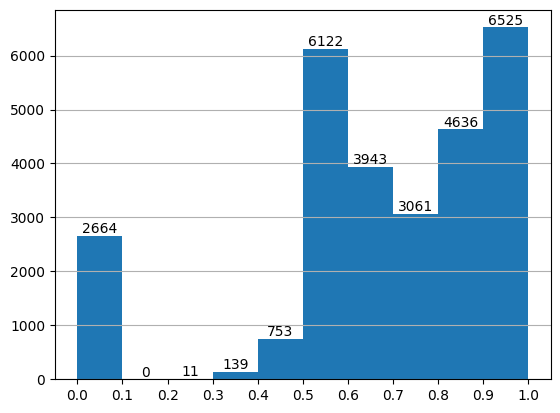

In [5]:
analyzer.plot_agreement_histogram()

In [6]:
from tqdm.auto import tqdm

agreement_thresholds = np.arange(0., 1., 0.01)
analyzer_alphas = []

for thresh in tqdm(agreement_thresholds):
    thresh = round(thresh, 8)
    analyzer.set_agreement_threshold(thresh)

    analyzer_alpha = analyzer.calculate_krippendorff_alpha()

    analyzer_alphas.append(analyzer_alpha)

  0%|          | 0/100 [00:00<?, ?it/s]

Acceptable analyzer threshold: 0.71


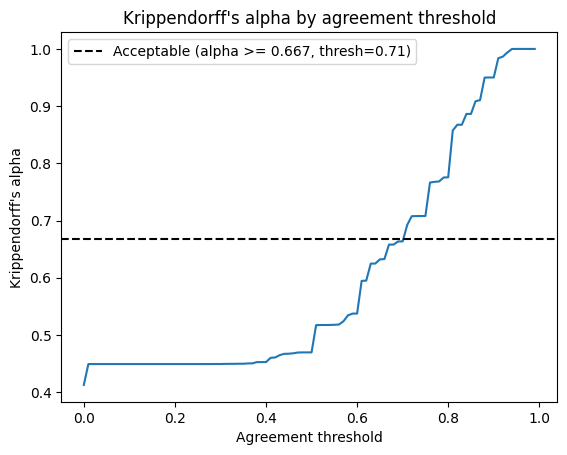

In [7]:
acceptable_thresh = 0.667

analyzer_alphas = np.array(analyzer_alphas)

acceptable_analyzer_thresh = agreement_thresholds[analyzer_alphas >= acceptable_thresh]

print(f"Acceptable analyzer threshold: {acceptable_analyzer_thresh[0]}")


plt.plot(agreement_thresholds, analyzer_alphas)
plt.axhline(0.667, color="black", linestyle="--", label=f"Acceptable (alpha >= 0.667, thresh={acceptable_analyzer_thresh[0]})")
plt.ylabel("Krippendorff's alpha")
plt.xlabel("Agreement threshold")
plt.title("Krippendorff's alpha by agreement threshold")
plt.legend()
plt.show()